# Ressources

In [1]:
import pandas as pd
import numpy as np
import missingno
from IPython.display import display, Image
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pycaret.classification import *

# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
import re

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import plotly.figure_factory as ff
import gc

# Garbage collection is to release memory when the object is no longer in use. This system destroys the unused object and reuses its memory slot for new objects. You can imagine this as a recycling system in computers.

import shap

import time
from contextlib import contextmanager

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from rich.console import Console

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fonctions
## Data

In [2]:

def comparaisons_colonnes(df1:pd.DataFrame, df2:pd.DataFrame):
    """Compare les colonnes de deux DF, et renvoient celles qui ne sont pas présentes dans les deux fichiers.

    Parameters
    -----------
    df1: :class:`DataFrame`

    df2: :class:`DataFrame`

            
    Return
    ----------
    Deux listes avec la différence dans le DataFrame 1 puis le DataFrame 2
    
    Exemples
    ----------
    list_1 = list(df_2015.columns)
    
    list_2 = list(df_2016.columns)

    dif1, dif2 = comparaisons_colonnes(df1, df2)
    """
    
    list_1 = list(df1.columns)
    list_2 = list(df2.columns)
    # Un set est un ensemble de clefs non ordonnées et non redondant où l'on peut savoir
    # si un élément est présent sans avoir à parcourir toute la liste (une sorte de dictionnaire où les valeurs seraient ignorées, seules les clefs comptent).
    dif_list_1_list_2 = list(set(list_1) - set(list_2))
    dif_list_2_list_1 = list(set(list_2) - set(list_1))
    nb_dif_list1_list_2 = len(dif_list_1_list_2)
    nb_dif_list2_list1 = len(dif_list_2_list_1)
    print(f'Colonnes présentes dans le df1, absentes dans le df2 ({nb_dif_list1_list_2}) : {dif_list_1_list_2}')
    print(f'Colonnes présentes dans le df2, absentes dans le df1 ({nb_dif_list2_list1}) : {dif_list_2_list_1}')
    

    
def identification_colonne_binaire(df, var_ignore=None):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if len_colonne == 2:
            col_binaire_name.append(df_identif.iloc[:,i].name)
            col_binaire_number.append(i)
            
            
            
    print(f'Colonnes binaires : {col_binaire_name}')
    print(f'Nombres : {len(col_binaire_number)}')
    
    return col_binaire_name, col_binaire_number


def identification_colonne_categorique(df, var_ignore=None, nb_valeurs_unique=2):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if nb_valeurs_unique == 2:
            if len_colonne == nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
        else:
            if len_colonne <= nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
            
            
    if var_ignore != None:
        df_identif[var_ignore] = df[var_ignore]
            
            
            
    print(f'Colonnes binaires : {col_binaire_name}')
    print(f'Nombres : {len(col_binaire_number)}')
    
    return df_identif


def distribution_target(train_df_test):
    distrib_target = train_df_test['TARGET'].value_counts()  / len(train_df_test['TARGET'])*100


    # fig = px.histogram(train_df_test, x="TARGET", color="TARGET", text_auto=True)

    # fig.show()

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribution", "Répartition"),
                            specs=[[{"type": "xy"}, {"type": "domain"}]])

    cat0 = train_df_test[train_df_test['TARGET']==0]['TARGET']
    cat1 = train_df_test[train_df_test['TARGET']==1]['TARGET']

    # fig.add_trace(go.Histogram(x=train_df_test['TARGET']), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat0, name="0", text=str(cat0.count())), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat1, name="1", text=str(cat1.count())), row=1, col=1)
    fig.add_trace(go.Pie(values=distrib_target.values), row=1, col=2)


    fig.update_layout(height=500, showlegend=False, title_text="TARGET")

    #x axis    
    fig.update_xaxes(visible=False)

    fig.show()

### Corrélation

In [3]:
def correlation_independante_et_dependante(df:pd.DataFrame, colonne:str, title:str):
        
        """Corrélation entre des variables indépendantes avec une variable dépendante.
        Renvoie une heatmap en une seule colonne

    Parameters
    -----------
    df: :class:`DataFrame`
            Le DataFrame
    colonne: :class:`str`
            La variable dépendante, où on va juger les corrélations des autres variables
    title: :class:`str`
            Titre du graphique
            
    Return
    ----------
    Graphique
    """
        
        f, ax = plt.subplots(figsize=(11, 20))

        heatmap = sns.heatmap(df.corr()[[colonne]].sort_values(by=colonne, ascending=False), annot=True)
        
        heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline

def cv_smoke(df):
        clf = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1)
    
        X = df.drop(['TARGET'], axis=1)
        y = df['TARGET']

        # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, random_state=0)   
        
        # steps = [('over', SMOTE()), ('model', clf)]
        # pip = Pipeline(steps=steps)
        
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
        scores = cross_val_score(clf, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
        
        print('Mean ROC AUC: %.3f' % np.mean(scores))
        

def lgbm_manuel(df):
    clf = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1)
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, random_state=0)

    clf.fit(X_train, y_train)
    
    display(f' Total : {roc_auc_score(y, clf.predict_proba(X)[:,1])}')
    display(f' Train : {roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])}')
    display(f'Test : {roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])}')

# Data formatée

In [5]:
# fichier application_test avec uniquement l'id et Target

data_test_clean = pd.read_csv('submission_kernel02.csv')
data_test_clean.rename(columns={'TARGET' : 'PROBA_TARGET'}, inplace=True)
data_test_clean

# Target = La probabilité prédite pour chaque classe pour chaque échantillon. Pourquoi dans un dataset séparé ?

,SK_ID_CURR,PROBA_TARGET
0,100001,0.034300
1,100005,0.146855
2,100013,0.027505
3,100028,0.038554
4,100038,0.153569
...,...,...
48739,456221,0.046247
48740,456222,0.060781
48741,456223,0.008308
48742,456224,0.026186


In [6]:
# Fichier application_train fusionnée
data_results = pd.read_csv('data_featured.csv')


In [7]:
data_results

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Choix de features


Nous avons 800 colonnes, on peut donc vite s'y perdre...


- Selection des features
- Gestion des NaN (essayer de les compléter ou ignorer)
- Cross validation
- SMOTE (sur le dataset d'entrainement)

### Commun

In [8]:
train_df_test = data_results[data_results['TARGET'].notnull()] # Target présent
test_df_test = data_results[data_results['TARGET'].isnull()] # Target NA

print(f"Train : {train_df_test.shape}")
print(f"Test : {test_df_test.shape}")



# Il y a des valeurs infinies dans le data_temp_x, on remplace par 0 (à voir ...)
if np.all(np.isfinite(train_df_test)) == False:
    train_df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    
# fix LGBM

# Fix LightGBMError do not support special Json character in feature name (Kevin). On remplace:
train_df_test = train_df_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Train : (307507, 797)
Test : (48744, 797)


#### Distribution de la variable Target

In [9]:
def distribution_target(train_df_test):
    distrib_target = train_df_test['TARGET'].value_counts()  / len(train_df_test['TARGET'])*100


    # fig = px.histogram(train_df_test, x="TARGET", color="TARGET", text_auto=True)

    # fig.show()

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribution", "Répartition"),
                            specs=[[{"type": "xy"}, {"type": "domain"}]])

    cat0 = train_df_test[train_df_test['TARGET']==0]['TARGET']
    cat1 = train_df_test[train_df_test['TARGET']==1]['TARGET']

    # fig.add_trace(go.Histogram(x=train_df_test['TARGET']), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat0, name="0", text=str(cat0.count())), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat1, name="1", text=str(cat1.count())), row=1, col=1)
    fig.add_trace(go.Pie(values=distrib_target.values), row=1, col=2)


    fig.update_layout(height=500, showlegend=False, title_text="TARGET")

    #x axis    
    fig.update_xaxes(visible=False)

    fig.show()
    
distribution_target(train_df_test)

### Fix Unbalanced 

L'accuracy et l'AUC sont très différents.
Cela implique que le training set a une distribution inégale des valeurs de Target, qui peut être fixé via SMOTE.

SMOTe génère des individus fictifs pour rebalancer le TARGET en densifiant les individus minoritaires de façon homogène.

#### Preprocessing (smotenc)

In [10]:
def pycaret_manuel_processing(df, imputer="SimpleImputer"):
    
    """ Imputer -> SelectFromModel -> SMOTE """
    
    # feature selection puis smote
    
    # on remplace les nan par la moyenne
    
    if imputer == "SimpleImputer":

        imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
        
    else:
        imp_mean = IterativeImputer(missing_values=np.nan, random_state=0)
    
    # on selectionne les meilleures colonnes basé sur les weights importance
    
    selector = SelectFromModel(LGBMClassifier(random_state=42), max_features=20).fit(df.drop("TARGET", axis=1), df['TARGET'])
    columns = selector.get_feature_names_out().tolist()
    display(f"Colonnes retenues : {columns}")
    
    # on ajoute la variable discriminante (TARGET)
    
    columns.append('TARGET')
    
    # on crée un nouveau dataframe avec les colonnes imputées
    
    train_df_test_imp = pd.DataFrame(imp_mean.fit_transform(df[columns]))
    train_df_test_imp.columns = columns
    
    try:
        train_df_test_imp.drop('index', axis=1, inplace=True)
    except:
        pass
    
    # Nous avons vu que le dataset d'entrainement est déséquilibré. Nous allons donc utiliser SMOTE pour le rebalancer.

    # sm = SMOTE(k_neighbors=5, sampling_strategy=0.75, random_state=42) # Pb avec code_gender
    
    # SMOTE ne sait pas travailler avec des catégories. En revanche SMOTENC peut....
    
    # train_df_test_imp['CODE_GENDER'] = train_df_test_imp['CODE_GENDER'].astype('category')
    
    # sm = SMOTENC(categorical_features=[0], k_neighbors=5, sampling_strategy=0.75, random_state=42, n_jobs=-1)

    # df_smote, df_smote['TARGET'] = sm.fit_resample(train_df_test_imp.drop(['TARGET'], axis=1), train_df_test_imp['TARGET'])
    
    return train_df_test_imp

In [11]:
df_preprocess = pycaret_manuel_processing(train_df_test)
df_preprocess

"Colonnes retenues : ['CODE_GENDER', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_CREDIT_PERC', 'PAYMENT_RATE', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_DAYS_CREDIT_MAX', 'PREV_CNT_PAYMENT_MEAN', 'APPROVED_CNT_PAYMENT_MEAN', 'INSTAL_DPD_MEAN', 'INSTAL_AMT_PAYMENT_SUM', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN']"

,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,EXT_SOURCE_1,EXT_SOURCE_2,...,INCOME_CREDIT_PERC,PAYMENT_RATE,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_DAYS_CREDIT_MAX,PREV_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN,INSTAL_AMT_PAYMENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,TARGET
0,0.0,406597.5,24700.5,351000.0,9461.0,-637.000000,-2120.0,12.061121,0.083037,0.262949,...,0.121978,0.060749,1681.029000,-103.000000,24.000000,24.000000,0.000000,219625.695,0.566241,1.0
1,1.0,1293502.5,35698.5,1129500.0,16765.0,-1188.000000,-291.0,12.061121,0.311267,0.622246,...,0.132217,0.027598,0.000000,-606.000000,10.000000,10.000000,0.000000,1618864.650,0.566241,0.0
2,0.0,135000.0,6750.0,135000.0,19046.0,-225.000000,-2531.0,26.000000,0.502129,0.555912,...,0.100000,0.050000,0.000000,-416.937369,4.000000,4.000000,0.000000,21288.465,0.566241,0.0
3,1.0,312682.5,29686.5,297000.0,19005.0,-3039.000000,-2437.0,12.061121,0.502129,0.650442,...,0.219900,0.094941,5242.460342,-416.937369,23.000000,18.000000,0.000000,1007153.415,0.566241,0.0
4,0.0,513000.0,21865.5,513000.0,19932.0,-3038.000000,-3458.0,12.061121,0.502129,0.322738,...,0.179963,0.042623,0.000000,-416.937369,20.666667,20.666667,0.954545,806127.975,0.566241,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,254700.0,27558.0,225000.0,9327.0,-236.000000,-1982.0,12.061121,0.145570,0.681632,...,0.174971,0.108198,5242.460342,-416.937369,8.000000,8.000000,0.000000,52450.470,0.566241,0.0
307503,1.0,269550.0,12001.5,225000.0,20775.0,-2384.142254,-4090.0,12.061121,0.502129,0.115992,...,0.166687,0.044524,5242.460342,-416.937369,6.000000,6.000000,0.500000,60419.205,0.566241,0.0
307504,1.0,677664.0,29979.0,585000.0,14966.0,-7921.000000,-5150.0,12.061121,0.744026,0.535722,...,0.195941,0.044239,5242.460342,-713.000000,5.000000,5.000000,0.642857,57622.815,0.566241,0.0
307505,1.0,370107.0,20205.0,319500.0,11961.0,-4786.000000,-931.0,12.061121,0.502129,0.514163,...,0.118158,0.054592,5242.460342,-416.937369,15.000000,15.000000,0.000000,194556.825,0.566241,1.0


##### Explication des variables


In [12]:
# a completer


# df_home_credit[df_home_credit['Row'].isin(['CODE_GENDER', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
                                        #    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'ACTIVE_DAYS_CREDIT', 'PREV_CNT_PAYMENT', 'APPROVED_CNT_PAYMENT', 'INSTAL_DPD', 'INSTAL_AMT_PAYMENT', 'INSTAL_DAYS_ENTRY_PAYMENT', 'CC_CNT_DRAWINGS_ATM_CURRENT'])]



##### Lightbgm

In [13]:
from rich.console import Console

def lightbgm(train_df, test_df, num_folds=10, stratified=False):
    console = Console()
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0]) # créer une array remplie de 0 qui aura les mêmes dimensions que le df
    sub_preds = np.zeros(test_df.shape[0]) # créer une array remplie de 0 qui aura les mêmes dimensions que le df
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # variables du DF qui ne sont pas dans la liste (Target est la variable à prédire, les autres n'ont pas d'impact sur la prédiction)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        # predit proba est utilisé pour prédire les possibilités de classe.
        # predit proba = % que la proba soit égale à 1 car [:,1]. Si on ne met rien, on a la proba pour 0 et 1.
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits # Retourne la probabilité prédite pour chaque classe pour chaque échantillon. # Pourquoi diviser ?

        
        # console.print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])), style="green")
        
    console.print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds), style="green")
        
        
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_kevin.csv', index= False)
    
    return clf, train_df, test_df, feats

In [14]:
clf, train_df, test_df, feats = lightbgm(df_preprocess, test_df_test.drop(['TARGET'], axis=1), num_folds=2)

[200]	training's auc: 0.788011	training's binary_logloss: 0.237866	valid_1's auc: 0.765555	valid_1's binary_logloss: 0.244867
[400]	training's auc: 0.807377	training's binary_logloss: 0.230162	valid_1's auc: 0.772055	valid_1's binary_logloss: 0.242379
[600]	training's auc: 0.818907	training's binary_logloss: 0.225703	valid_1's auc: 0.773604	valid_1's binary_logloss: 0.241877
[800]	training's auc: 0.828446	training's binary_logloss: 0.222048	valid_1's auc: 0.773756	valid_1's binary_logloss: 0.24185
[200]	training's auc: 0.788807	training's binary_logloss: 0.23774	valid_1's auc: 0.763386	valid_1's binary_logloss: 0.245049
[400]	training's auc: 0.807493	training's binary_logloss: 0.23029	valid_1's auc: 0.770269	valid_1's binary_logloss: 0.242575
[600]	training's auc: 0.820082	training's binary_logloss: 0.225499	valid_1's auc: 0.772309	valid_1's binary_logloss: 0.241958
[800]	training's auc: 0.829564	training's binary_logloss: 0.221839	valid_1's auc: 0.772971	valid_1's binary_logloss: 0.24

Full AUC score 0.773464

##### Explication 

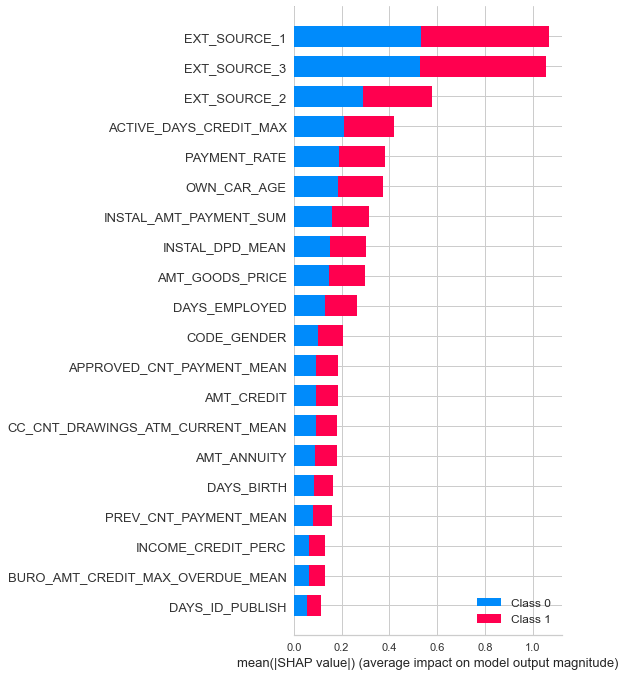

In [15]:
# Source : https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(test_df[feats])
    
shap.summary_plot(shap_values, test_df[feats], feature_names=feats, max_display=20, show=False)

plt.savefig('./img/explain_shape.png')
plt.show()

### Test avec iterative

In [16]:
df_preprocess2 = pycaret_manuel_processing(train_df_test, "iterative")
df_preprocess2

"Colonnes retenues : ['CODE_GENDER', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_CREDIT_PERC', 'PAYMENT_RATE', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_DAYS_CREDIT_MAX', 'PREV_CNT_PAYMENT_MEAN', 'APPROVED_CNT_PAYMENT_MEAN', 'INSTAL_DPD_MEAN', 'INSTAL_AMT_PAYMENT_SUM', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN']"

,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,EXT_SOURCE_1,EXT_SOURCE_2,...,INCOME_CREDIT_PERC,PAYMENT_RATE,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_DAYS_CREDIT_MAX,PREV_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_MEAN,INSTAL_DPD_MEAN,INSTAL_AMT_PAYMENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,TARGET
0,0.0,406597.5,24700.5,351000.0,9461.0,-637.000000,-2120.0,14.862444,0.083037,0.262949,...,0.121978,0.060749,1681.029000,-103.000000,24.000000,24.000000,0.000000,219625.695,0.921487,1.0
1,1.0,1293502.5,35698.5,1129500.0,16765.0,-1188.000000,-291.0,15.375532,0.311267,0.622246,...,0.132217,0.027598,0.000000,-606.000000,10.000000,10.000000,0.000000,1618864.650,1.267775,0.0
2,0.0,135000.0,6750.0,135000.0,19046.0,-225.000000,-2531.0,26.000000,0.496367,0.555912,...,0.100000,0.050000,0.000000,-670.257501,4.000000,4.000000,0.000000,21288.465,0.037798,0.0
3,1.0,312682.5,29686.5,297000.0,19005.0,-3039.000000,-2437.0,12.175440,0.671719,0.650442,...,0.219900,0.094941,6292.456571,-476.783974,23.000000,18.000000,0.000000,1007153.415,0.345446,0.0
4,0.0,513000.0,21865.5,513000.0,19932.0,-3038.000000,-3458.0,13.153882,0.544354,0.322738,...,0.179963,0.042623,0.000000,-472.871337,20.666667,20.666667,0.954545,806127.975,0.367891,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,254700.0,27558.0,225000.0,9327.0,-236.000000,-1982.0,14.539454,0.145570,0.681632,...,0.174971,0.108198,20156.271233,-403.352597,8.000000,8.000000,0.000000,52450.470,0.776216,0.0
307503,1.0,269550.0,12001.5,225000.0,20775.0,-3678.989885,-4090.0,15.429091,0.641499,0.115992,...,0.166687,0.044524,2771.095158,-416.892596,6.000000,6.000000,0.500000,60419.205,0.551494,0.0
307504,1.0,677664.0,29979.0,585000.0,14966.0,-7921.000000,-5150.0,11.502156,0.744026,0.535722,...,0.195941,0.044239,89361.296409,-713.000000,5.000000,5.000000,0.642857,57622.815,0.493162,0.0
307505,1.0,370107.0,20205.0,319500.0,11961.0,-4786.000000,-931.0,13.058211,0.418772,0.514163,...,0.118158,0.054592,6269.589945,-506.528664,15.000000,15.000000,0.000000,194556.825,0.620946,1.0


In [17]:
clf, train_df, test_df, feats = lightbgm(df_preprocess2, test_df_test.drop(['TARGET'], axis=1), num_folds=2)

[200]	training's auc: 0.868299	training's binary_logloss: 0.200877	valid_1's auc: 0.852104	valid_1's binary_logloss: 0.208215
[400]	training's auc: 0.889751	training's binary_logloss: 0.187282	valid_1's auc: 0.866203	valid_1's binary_logloss: 0.199471
[600]	training's auc: 0.903272	training's binary_logloss: 0.178347	valid_1's auc: 0.873343	valid_1's binary_logloss: 0.194744
[800]	training's auc: 0.914015	training's binary_logloss: 0.170847	valid_1's auc: 0.87856	valid_1's binary_logloss: 0.191161
[1000]	training's auc: 0.922313	training's binary_logloss: 0.164674	valid_1's auc: 0.881984	valid_1's binary_logloss: 0.188606
[1200]	training's auc: 0.929178	training's binary_logloss: 0.15948	valid_1's auc: 0.884527	valid_1's binary_logloss: 0.186762
[1400]	training's auc: 0.935103	training's binary_logloss: 0.15464	valid_1's auc: 0.886456	valid_1's binary_logloss: 0.185195
[1600]	training's auc: 0.940381	training's binary_logloss: 0.150199	valid_1's auc: 0.8882	valid_1's binary_logloss: 0.

Full AUC score 0.900007

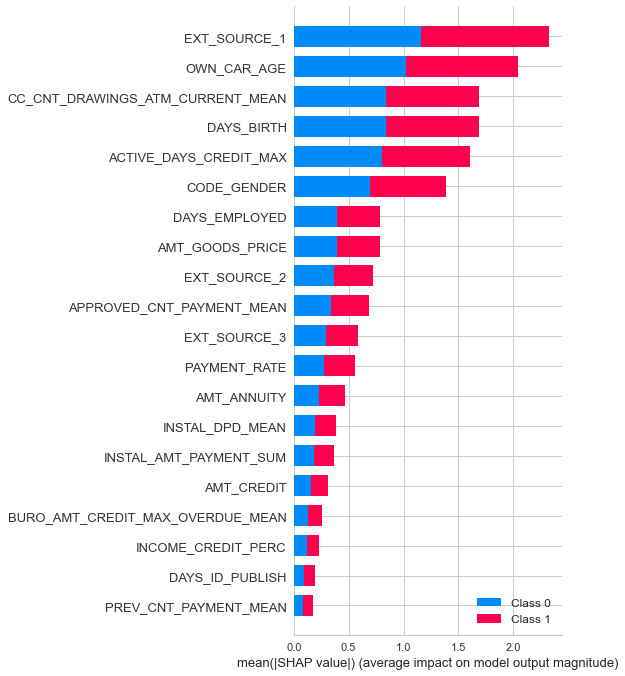

In [18]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(test_df[feats])
    
shap.summary_plot(shap_values, test_df[feats], feature_names=feats, max_display=20, show=False)

plt.savefig('./img/explain_shape.png')
plt.show()

### GridSearchCV

Feature selection puis  SMOTE

In [19]:
def imputation(df, imputer="SimpleImputer"):
    
    """Selection features -> Imputer"""
    
    if imputer =="SimpleImputer":
        imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
    else:
        imp_mean = IterativeImputer(missing_values = np.nan, random_state=0)
        
        # on selectionne les meilleures colonnes basé sur les weights importance
        
    selector = SelectFromModel(LGBMClassifier(random_state=42), max_features=20).fit(df.drop("TARGET", axis=1), df['TARGET'])
    columns = selector.get_feature_names_out().tolist()
    display(f"Colonnes retenues : {columns}")
        
        # on ajoute la variable discriminante (TARGET)
        
    columns.append('TARGET')
        
        # on crée un nouveau dataframe avec les colonnes imputées
        
    train_df_test_imp = pd.DataFrame(imp_mean.fit_transform(df[columns]))
    train_df_test_imp.columns = columns
    
    return train_df_test_imp

In [20]:
train_df_test_grid = imputation(train_df_test)
train_df_test_grid = identification_colonne_categorique(train_df_test_grid, 'TARGET')

category_mask = train_df_test_grid.dtypes == object



"Colonnes retenues : ['CODE_GENDER', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_CREDIT_PERC', 'PAYMENT_RATE', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_DAYS_CREDIT_MAX', 'PREV_CNT_PAYMENT_MEAN', 'APPROVED_CNT_PAYMENT_MEAN', 'INSTAL_DPD_MEAN', 'INSTAL_AMT_PAYMENT_SUM', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN']"

Colonnes binaires : ['CODE_GENDER']
Nombres : 1


In [21]:
train_df_test_grid['CODE_GENDER'] = train_df_test_grid['CODE_GENDER'].astype('int')

In [22]:
# https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

sm = SMOTENC(categorical_features=category_mask, sampling_strategy=0.75, random_state=42, n_jobs=-1)
    
model = Pipeline([
        ('sampling', sm),
        ('classification', LGBMClassifier())
    ])
    

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'sampling__k_neighbors' : [3, 4 , 5], 'sampling__sampling_strategy' : [0.40, 0.50, 0.60, 0.75, 'auto']}

grid_search = GridSearchCV(estimator=model,
                           param_grid = param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=1)

X_train, X_test, y_train, y_test = train_test_split(train_df_test_grid.drop(['TARGET'], axis=1), train_df_test_grid['TARGET'],
                                                        test_size=0.3,
                                                        stratify=train_df_test_grid['TARGET'],
                                                        random_state=11)


grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_

test_score = grid_search.score(X_test, y_test)

display(f"Score : {cv_score}")
display(f"Score sur data test : {test_score}")


'Score : 0.7279096253789251'

'Score sur data test : 0.725498915785256'